In [9]:
#libraries
library(tidyverse)
library(repr)
library(tidymodels)
options(repr.matrix.max.rows = 6)
library(lubridate)

# Project report
### Group 25: Nelson, Will, Caroline

### Introduction

This report looks at two data sets from a Minecraft server set up by a computer science research group at the University of British Columbia. The researchers collected data about how people play games by recording players’ actions on the server. However, in order to run the project, the researchers need to figure out how to attract more players for their server and manage resources. One such method is to advertise on a game-related newsletter, but since not every player on the server is subscribed to it, it can limit their recruitment ability.  

Here, we will try to answer the following question: 
_Can we predict whether a player will subscribe to the game’s newsletter based on their age, total hours played and average session length?_

In order to answer this question, we will use both the players and sessions data. Some details of the two datasets are listed below:

#### Players.csv

Rows: 196

Columns: 7

**Variables**

- experience: Categorical variable giving experience level.

- subscribe: Categorical variable reporting subscription status.

- hashedEmail: Categorical variable containing each players hashed email.

- played_hours: double containing each player's total played hours.

- name: Categorical variable containing each player's first name.

- gender: Categorical variable containing player's gender.

- Age: double variable giving the age of each player.

**Summary Statistics**

There are 196 players on the server in total.

124 players are male, 37 are female, 33 identify as other or didn't state their gender.

35 players are beginners, 35 are regulars, 63 are amateurs, 48 are veterans, and 13 are pros.

144 players are subscribed to the newsletter, while 52 players are not.

_Note: name, gender, and experience level are likely self reported so may be inaccurate for some observations. Some cells have missing values._


#### Sessions.csv

Rows: 1535

Columns: 5

**Variables**

- hashedEmail: Same as players data

- start_time, end_time: Contains character formatted session start and end times

- original_start_time, original_end_time: Both doubles, containing each session’s start and end times in milliseconds as stored by the server. However they appear to contain identical values for some given observations which is possibly an issue.

**Summary Statistics**

Average sessions per player: 12.26

Most sessions by one player: 310

_Note: Session counts per player appear to be very skewed due to a few heavy users._


In [10]:
# importing the data
players_data <- read_csv("data/players.csv")
sessions_data <- read_csv("data/sessions.csv")
players_data
sessions_data

Rows: 196 Columns: 7
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (4): experience, hashedEmail, name, gender
dbl (2): played_hours, Age
lgl (1): subscribe

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 1535 Columns: 5
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (3): hashedEmail, start_time, end_time
dbl (2): original_start_time, original_end_time

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


experience,subscribe,hashedEmail,played_hours,name,gender,Age
<chr>,<lgl>,<chr>,<dbl>,<chr>,<chr>,<dbl>
Pro,TRUE,f6daba428a5e19a3d47574858c13550499be23603422e6a0ee9728f8b53e192d,30.3,Morgan,Male,9
Veteran,TRUE,f3c813577c458ba0dfef80996f8f32c93b6e8af1fa939732842f2312358a88e9,3.8,Christian,Male,17
Veteran,FALSE,b674dd7ee0d24096d1c019615ce4d12b20fcbff12d79d3c5a9d2118eb7ccbb28,0.0,Blake,Male,17
⋮,⋮,⋮,⋮,⋮,⋮,⋮
Amateur,FALSE,d572f391d452b76ea2d7e5e53a3d38bfd7499c7399db299bd4fedb06a46ad5bb,0.0,Dylan,Prefer not to say,57
Amateur,FALSE,f19e136ddde68f365afc860c725ccff54307dedd13968e896a9f890c40aea436,2.3,Harlow,Male,17
Pro,TRUE,d9473710057f7d42f36570f0be83817a4eea614029ff90cf50d8889cdd729d11,0.2,Ahmed,Other,NA


hashedEmail,start_time,end_time,original_start_time,original_end_time
<chr>,<chr>,<chr>,<dbl>,<dbl>
bfce39c89d6549f2bb94d8064d3ce69dc3d7e72b38f431d8aa0c4bf95ccee6bf,30/06/2024 18:12,30/06/2024 18:24,1.71977e+12,1.71977e+12
36d9cbb4c6bc0c1a6911436d2da0d09ec625e43e6552f575d4acc9cf487c4686,17/06/2024 23:33,17/06/2024 23:46,1.71867e+12,1.71867e+12
f8f5477f5a2e53616ae37421b1c660b971192bd8ff77e3398304c7ae42581fdc,25/07/2024 17:34,25/07/2024 17:57,1.72193e+12,1.72193e+12
⋮,⋮,⋮,⋮,⋮
fd6563a4e0f6f4273580e5fedbd8dda64990447aea5a33cbb5e894a3867ca44d,28/07/2024 15:36,28/07/2024 15:57,1.72218e+12,1.72218e+12
fd6563a4e0f6f4273580e5fedbd8dda64990447aea5a33cbb5e894a3867ca44d,25/07/2024 06:15,25/07/2024 06:22,1.72189e+12,1.72189e+12
36d9cbb4c6bc0c1a6911436d2da0d09ec625e43e6552f575d4acc9cf487c4686,20/05/2024 02:26,20/05/2024 02:45,1.71617e+12,1.71617e+12


In [11]:
# tidys data and computes summary stats
#removing any rows with na values, making name formats consistent

# renamed things so I could work on the data more easily please have mercy I know its unecesary but it was helpfull 
sessions_tidy <- sessions_data |>
na.omit() |>
mutate(hashed_email = hashedEmail, hashedEmail = NULL,)

sessions_tidy

players_tidy <- players_data |>
na.omit() |>
mutate(age = Age, Age = NULL, 
       hashed_email = hashedEmail, hashedEmail = NULL,
      )

players_tidy

#computing summary statistics for players data and formatting for readbility
players_summary <-players_tidy |>
    summarize(
        played_hours = mean(played_hours),
        age = mean(age),   
    ) |>
    pivot_longer(1:2, names_to = "variable", values_to = "mean value")
players_summary


#computing number of players from each gender 
players_summary <- players_tidy |> 
    group_by(gender) |>
    summarize(n())

#computing the number of players in each skill level 
players_summary <- players_tidy |> 
    group_by(experience) |>
    summarize(n())

#computer summary statistics for sessions data:

#finding average number of sessions per player:
sessions_summary <- sessions_tidy |>
    group_by(hashed_email) |>
    summarize(num_sessions = n()) |>
    ungroup() |>
    summarize(mean_sessions = mean(num_sessions))

#finding max sessions by one player
sessions_summary <- sessions_tidy |>
    group_by(hashed_email) |>
    summarize(num_sessions=n()) |>
    arrange(desc(num_sessions))


start_time,end_time,original_start_time,original_end_time,hashed_email
<chr>,<chr>,<dbl>,<dbl>,<chr>
30/06/2024 18:12,30/06/2024 18:24,1.71977e+12,1.71977e+12,bfce39c89d6549f2bb94d8064d3ce69dc3d7e72b38f431d8aa0c4bf95ccee6bf
17/06/2024 23:33,17/06/2024 23:46,1.71867e+12,1.71867e+12,36d9cbb4c6bc0c1a6911436d2da0d09ec625e43e6552f575d4acc9cf487c4686
25/07/2024 17:34,25/07/2024 17:57,1.72193e+12,1.72193e+12,f8f5477f5a2e53616ae37421b1c660b971192bd8ff77e3398304c7ae42581fdc
⋮,⋮,⋮,⋮,⋮
28/07/2024 15:36,28/07/2024 15:57,1.72218e+12,1.72218e+12,fd6563a4e0f6f4273580e5fedbd8dda64990447aea5a33cbb5e894a3867ca44d
25/07/2024 06:15,25/07/2024 06:22,1.72189e+12,1.72189e+12,fd6563a4e0f6f4273580e5fedbd8dda64990447aea5a33cbb5e894a3867ca44d
20/05/2024 02:26,20/05/2024 02:45,1.71617e+12,1.71617e+12,36d9cbb4c6bc0c1a6911436d2da0d09ec625e43e6552f575d4acc9cf487c4686


experience,subscribe,played_hours,name,gender,age,hashed_email
<chr>,<lgl>,<dbl>,<chr>,<chr>,<dbl>,<chr>
Pro,TRUE,30.3,Morgan,Male,9,f6daba428a5e19a3d47574858c13550499be23603422e6a0ee9728f8b53e192d
Veteran,TRUE,3.8,Christian,Male,17,f3c813577c458ba0dfef80996f8f32c93b6e8af1fa939732842f2312358a88e9
Veteran,FALSE,0.0,Blake,Male,17,b674dd7ee0d24096d1c019615ce4d12b20fcbff12d79d3c5a9d2118eb7ccbb28
⋮,⋮,⋮,⋮,⋮,⋮,⋮
Veteran,FALSE,0.3,Pascal,Male,22,71453e425f07d10da4fa2b349c83e73ccdf0fb3312f778b35c5802c3292c87bd
Amateur,FALSE,0.0,Dylan,Prefer not to say,57,d572f391d452b76ea2d7e5e53a3d38bfd7499c7399db299bd4fedb06a46ad5bb
Amateur,FALSE,2.3,Harlow,Male,17,f19e136ddde68f365afc860c725ccff54307dedd13968e896a9f890c40aea436


variable,mean value
<chr>,<dbl>
played_hours,5.904639
age,21.139175


In [12]:
# create a table with hashedEmail and average session length
new_sessions_data <- sessions_data |>
    mutate(session_length_mins = as.numeric(dmy_hm(end_time) - dmy_hm(start_time))) |> 
    select(hashedEmail, session_length_mins) |>
    group_by(hashedEmail) |> 
    summarize(average_session_length = mean(session_length_mins))

new_sessions_data

#adds each player's average playtime to players_data by hashedEmail.
#join only if player is in players_data, if a player did not have any sessions, set average_session_length to 0
joined_table <- players_data |>
    left_join(new_sessions_data, join_by(hashedEmail)) |>
    mutate(subscribe = as.factor(subscribe)) |>
    mutate(average_session_length = replace_na(average_session_length, 0))

joined_table

#check if any columns contain any NA values
colSums(is.na(joined_table))

#remove 2 rows with NA values in Age Column
final_table <- joined_table |>
    filter(!is.na(Age))

final_table

hashedEmail,average_session_length
<chr>,<dbl>
0088b5e134c3f0498a18c7ea6b8d77b4b0ff1636fc93355ccc95b45423367832,53
060aca80f8cfbf1c91553a72f4d5ec8034764b05ab59fe8e1cf0eee9a7b67967,30
0ce7bfa910d47fc91f21a7b3acd8f33bde6db57912ce0290fa0437ce0b97f387,11
⋮,⋮
fd6563a4e0f6f4273580e5fedbd8dda64990447aea5a33cbb5e894a3867ca44d,15.46774
fe218a05c6c3fc6326f4f151e8cb75a2a9fa29e22b110d4c311fb58fb211f471,9.00000
fef4e1bed8c3f6dcd7bcd39ab21bd402386155b2ff8c8e53683e1d2793bf1ed1,72.00000


experience,subscribe,hashedEmail,played_hours,name,gender,Age,average_session_length
<chr>,<fct>,<chr>,<dbl>,<chr>,<chr>,<dbl>,<dbl>
Pro,TRUE,f6daba428a5e19a3d47574858c13550499be23603422e6a0ee9728f8b53e192d,30.3,Morgan,Male,9,74.77778
Veteran,TRUE,f3c813577c458ba0dfef80996f8f32c93b6e8af1fa939732842f2312358a88e9,3.8,Christian,Male,17,85.00000
Veteran,FALSE,b674dd7ee0d24096d1c019615ce4d12b20fcbff12d79d3c5a9d2118eb7ccbb28,0.0,Blake,Male,17,5.00000
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
Amateur,FALSE,d572f391d452b76ea2d7e5e53a3d38bfd7499c7399db299bd4fedb06a46ad5bb,0.0,Dylan,Prefer not to say,57,5.00000
Amateur,FALSE,f19e136ddde68f365afc860c725ccff54307dedd13968e896a9f890c40aea436,2.3,Harlow,Male,17,29.83333
Pro,TRUE,d9473710057f7d42f36570f0be83817a4eea614029ff90cf50d8889cdd729d11,0.2,Ahmed,Other,NA,15.00000


experience              subscribe            hashedEmail 
                     0                      0                      0 
          played_hours                   name                 gender 
                     0                      0                      0 
                   Age average_session_length 
                     2                      0

experience,subscribe,hashedEmail,played_hours,name,gender,Age,average_session_length
<chr>,<fct>,<chr>,<dbl>,<chr>,<chr>,<dbl>,<dbl>
Pro,TRUE,f6daba428a5e19a3d47574858c13550499be23603422e6a0ee9728f8b53e192d,30.3,Morgan,Male,9,74.77778
Veteran,TRUE,f3c813577c458ba0dfef80996f8f32c93b6e8af1fa939732842f2312358a88e9,3.8,Christian,Male,17,85.00000
Veteran,FALSE,b674dd7ee0d24096d1c019615ce4d12b20fcbff12d79d3c5a9d2118eb7ccbb28,0.0,Blake,Male,17,5.00000
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
Veteran,FALSE,71453e425f07d10da4fa2b349c83e73ccdf0fb3312f778b35c5802c3292c87bd,0.3,Pascal,Male,22,21.00000
Amateur,FALSE,d572f391d452b76ea2d7e5e53a3d38bfd7499c7399db299bd4fedb06a46ad5bb,0.0,Dylan,Prefer not to say,57,5.00000
Amateur,FALSE,f19e136ddde68f365afc860c725ccff54307dedd13968e896a9f890c40aea436,2.3,Harlow,Male,17,29.83333


In [13]:
set.seed(123) 

#split data into training and testing sets
players_split <- initial_split(final_table, prop = 0.75, strata = subscribe)
players_train <- training(players_split)
players_test <- testing(players_split)

In [14]:
set.seed(123) 
#create recipe
player_recipe <- recipe(subscribe ~ played_hours + Age + average_session_length, data = players_train) |>
    step_center(all_predictors()) |>
    step_scale(all_predictors())

#create knn tune spec
knn_tune <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
    set_engine("kknn") |>
    set_mode("classification")

#test the number of neighbors (1-15)
k_vals <- tibble(neighbors = seq(from = 1, to = 15, by = 1))

#cross validation with 5 folds
players_vfold <- vfold_cv(players_train, v = 5, strata = subscribe)

#get metrics for k
players_results <- workflow() |>
    add_recipe(player_recipe) |>
    add_model(knn_tune) |>
    tune_grid(resamples = players_vfold, grid = k_vals) |>
    collect_metrics()

players_results

neighbors,.metric,.estimator,mean,n,std_err,.config
<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
1,accuracy,binary,0.4965025,5,0.04675110,Preprocessor1_Model01
1,roc_auc,binary,0.4996753,5,0.04511681,Preprocessor1_Model01
2,accuracy,binary,0.4967488,5,0.04456579,Preprocessor1_Model02
⋮,⋮,⋮,⋮,⋮,⋮,⋮
14,roc_auc,binary,0.6099065,5,0.04013344,Preprocessor1_Model14
15,accuracy,binary,0.7444828,5,0.01834729,Preprocessor1_Model15
15,roc_auc,binary,0.5975649,5,0.03769665,Preprocessor1_Model15


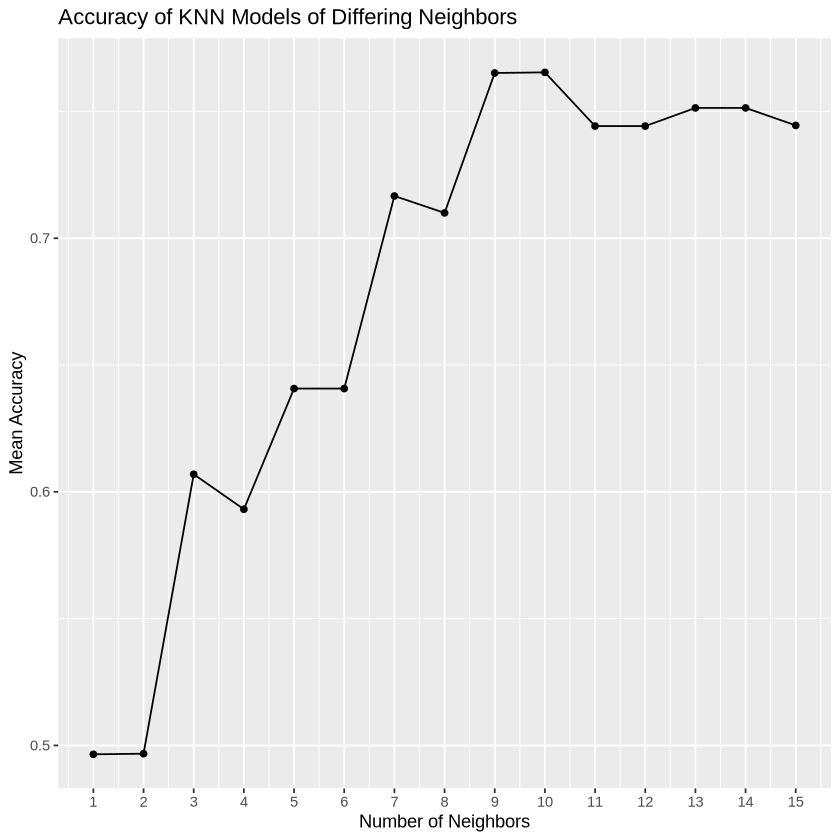

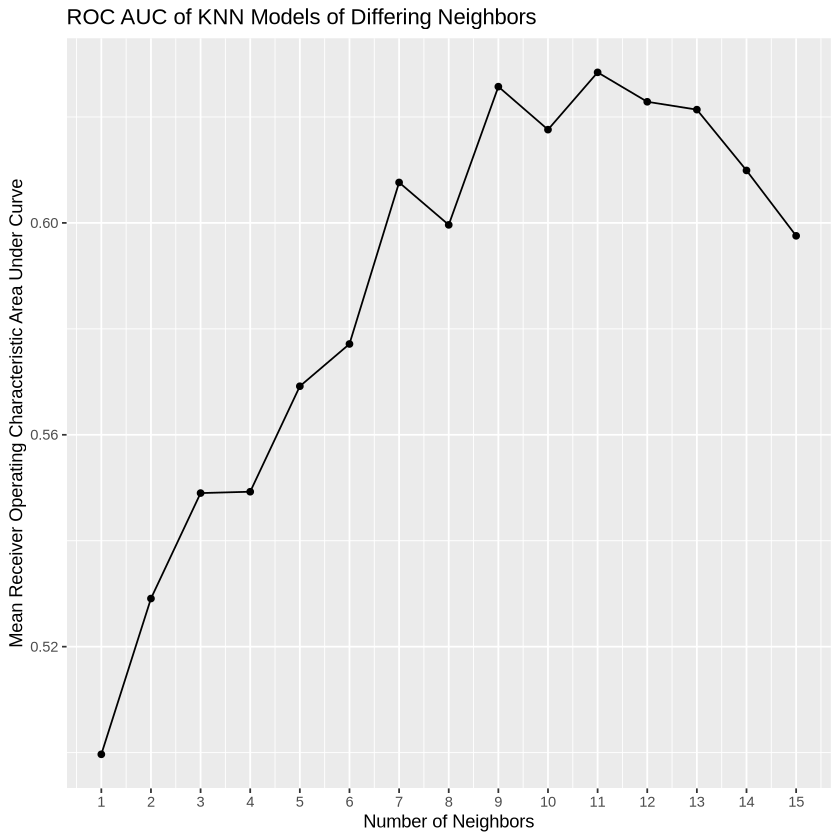

In [15]:
accuracies <- players_results |>
    filter(.metric == "accuracy")

#plot k values vs mean accuracy
accuracy_plot <- accuracies |>
    ggplot(aes(x = neighbors, y = mean)) +
    geom_point() +
    geom_line() +
    labs(x = "Number of Neighbors", y = "Mean Accuracy", title = "Accuracy of KNN Models of Differing Neighbors") +
    scale_x_continuous(breaks = seq(0, 15, by = 1))



#assess ROC AUC scores
#ROC AUC is used instead of accuracy because the subscription status is 3:1 in favour of yes, data isn't balanced
roc_auc <- players_results |>
    filter(.metric == "roc_auc")

#plot k values vs mean ROC AUC
roc_auc_plot <- roc_auc |>
    ggplot(aes(x = neighbors, y = mean)) +
    geom_point() +
    geom_line() +
    labs(x = "Number of Neighbors", y = "Mean Receiver Operating Characteristic Area Under Curve", title = "ROC AUC of KNN Models of Differing Neighbors") +
    scale_x_continuous(breaks = seq(0, 15, by = 1))

#shows the ROC AUC when k = 11
accuracy_plot
roc_auc_plot

#roc_auc may be a better metric because the data is not very balanced (75% are subscribed)

In [21]:
#create a new model with the otimal amount of neighbors
knn_11n <- nearest_neighbor(weight_func = "rectangular", neighbors = 11) |>
    set_engine("kknn") |>
    set_mode("classification")

#create a new fit with the optimal model
players_fit <- workflow() |>
    add_recipe(player_recipe) |>
    add_model(knn_11n) |>
    fit(data = players_train)

#predit on the test set
players_predictions <- predict(players_fit, players_test) |>
    bind_cols(players_test)

players_predictions

#create metrics for predictions
players_metrics <- players_predictions |>
    metrics(truth = subscribe, estimate = .pred_class)

players_metrics

#create confusion matrix
players_conf_mat <- players_predictions |>
    conf_mat(truth = subscribe, estimate = .pred_class)

players_conf_mat

.pred_class,experience,subscribe,hashedEmail,played_hours,name,gender,Age,average_session_length
<fct>,<chr>,<fct>,<chr>,<dbl>,<chr>,<chr>,<dbl>,<dbl>
TRUE,Veteran,TRUE,f3c813577c458ba0dfef80996f8f32c93b6e8af1fa939732842f2312358a88e9,3.8,Christian,Male,17,85
TRUE,Veteran,FALSE,b674dd7ee0d24096d1c019615ce4d12b20fcbff12d79d3c5a9d2118eb7ccbb28,0.0,Blake,Male,17,5
TRUE,Amateur,TRUE,23fe711e0e3b77f1da7aa221ab1192afe21648d47d2b4fa7a5a659ff443a0eb5,0.7,Flora,Female,21,50
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
TRUE,Beginner,TRUE,8c9d043ebb3689e679a37bfed30ea96272bcd14689ed2d9fcd68a4ae0c1663bc,0,Lina,Female,17,0
TRUE,Amateur,FALSE,514ebbaa30f0d162127e065ab780892b7930cf8d75944d5eb09c91c02d6026c7,0,Orion,Male,17,0
TRUE,Amateur,TRUE,644fe4200c19a73768b3fa598afcbd0948f7557925b7f17166285da23af31cc6,0,Rhys,Male,20,0


.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.7346939
kap,binary,0.1262003


          Truth
Prediction FALSE TRUE
     FALSE     2    2
     TRUE     11   34